# Liver cirrhosis prediction using XGboost and Stratified K-fold⚕
# Summary : 
Liver cirrhosis is a widespread problem especially in North America due to high intake of alcohol. In this project, we will predict liver cirrhosis in a patient based on certain lifestyle and health conditions of a patient.

Cirrhosis is a late stage of scarring (fibrosis) of the liver caused by many forms of liver diseases and conditions, such as hepatitis and chronic alcoholism. 

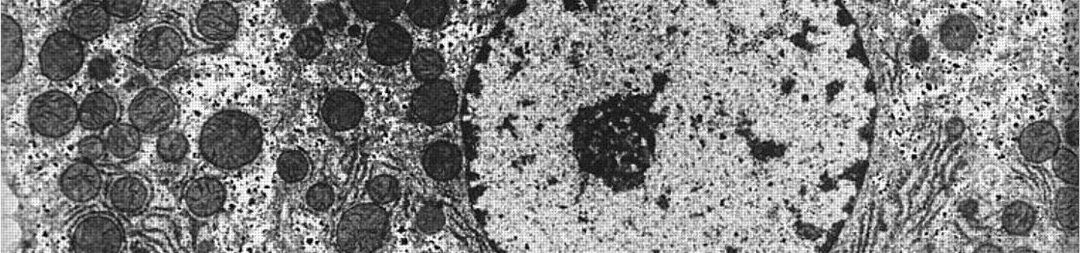

# Imports 

In [1]:
# %load_ext google.colab.data_table
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Lets Load the data and have a quick look.

In [2]:
#@title Default title text
df = pd.read_csv('cirrhosis.csv', index_col='ID')
df.head()

,N_Days,Status,Drug,Age,Sex,Ascites,Hepatomegaly,Spiders,Edema,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage
ID,,,,,,,,,,,,,,,,,,,
1,400,D,D-penicillamine,21464,F,Y,Y,Y,Y,14.5,261.0,2.60,156.0,1718.0,137.95,172.0,190.0,12.2,4.0
2,4500,C,D-penicillamine,20617,F,N,Y,Y,N,1.1,302.0,4.14,54.0,7394.8,113.52,88.0,221.0,10.6,3.0
3,1012,D,D-penicillamine,25594,M,N,N,N,S,1.4,176.0,3.48,210.0,516.0,96.10,55.0,151.0,12.0,4.0
4,1925,D,D-penicillamine,19994,F,N,Y,Y,S,1.8,244.0,2.54,64.0,6121.8,60.63,92.0,183.0,10.3,4.0
5,1504,CL,Placebo,13918,F,N,Y,Y,N,3.4,279.0,3.53,143.0,671.0,113.15,72.0,136.0,10.9,3.0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 418 entries, 1 to 418
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   N_Days         418 non-null    int64  
 1   Status         418 non-null    object 
 2   Drug           312 non-null    object 
 3   Age            418 non-null    int64  
 4   Sex            418 non-null    object 
 5   Ascites        312 non-null    object 
 6   Hepatomegaly   312 non-null    object 
 7   Spiders        312 non-null    object 
 8   Edema          418 non-null    object 
 9   Bilirubin      418 non-null    float64
 10  Cholesterol    284 non-null    float64
 11  Albumin        418 non-null    float64
 12  Copper         310 non-null    float64
 13  Alk_Phos       312 non-null    float64
 14  SGOT           312 non-null    float64
 15  Tryglicerides  282 non-null    float64
 16  Platelets      407 non-null    float64
 17  Prothrombin    416 non-null    float64
 18  Stage          

This data set has about 19 features. These features are related to the patient’s details like age, sex, etc. and patient’s blood tests like prothrombin, triglycerides, platelets levels, etc. All these factors help in understanding a patient’s chances of liver cirrhosis.

we have some NA values in our data, lets look at some statistical summary of numerical columns in out dataset.

In [4]:
df.describe()

,N_Days,Age,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage
count,418.000000,418.000000,418.000000,284.000000,418.000000,310.000000,312.000000,312.000000,282.000000,407.000000,416.000000,412.000000
mean,1917.782297,18533.351675,3.220813,369.510563,3.497440,97.648387,1982.655769,122.556346,124.702128,257.024570,10.731731,3.024272
std,1104.672992,3815.845055,4.407506,231.944545,0.424972,85.613920,2140.388824,56.699525,65.148639,98.325585,1.022000,0.882042
min,41.000000,9598.000000,0.300000,120.000000,1.960000,4.000000,289.000000,26.350000,33.000000,62.000000,9.000000,1.000000
25%,1092.750000,15644.500000,0.800000,249.500000,3.242500,41.250000,871.500000,80.600000,84.250000,188.500000,10.000000,2.000000
50%,1730.000000,18628.000000,1.400000,309.500000,3.530000,73.000000,1259.000000,114.700000,108.000000,251.000000,10.600000,3.000000
75%,2613.500000,21272.500000,3.400000,400.000000,3.770000,123.000000,1980.000000,151.900000,151.000000,318.000000,11.100000,4.000000
max,4795.000000,28650.000000,28.000000,1775.000000,4.640000,588.000000,13862.400000,457.250000,598.000000,721.000000,18.000000,4.000000


## We have some missing values in our data, lets see how many and in which columns.

In [5]:
df.isna().sum()

N_Days             0
Status             0
Drug             106
Age                0
Sex                0
Ascites          106
Hepatomegaly     106
Spiders          106
Edema              0
Bilirubin          0
Cholesterol      134
Albumin            0
Copper           108
Alk_Phos         106
SGOT             106
Tryglicerides    136
Platelets         11
Prothrombin        2
Stage              6
dtype: int64

# Handling Missing Values
This is a problem, we could just get rid of all examples with NA values, but in this case our case of small dataset we cannot afford that. 

We will impute the missing entries with some statistical calculations.

# We have two different types of data
1. Numerical data  ( Age, Cholesterol, Platelets.. etc)
2. Categorical Data ( Drug, Sex, Spiders..etc)

We will have to use different imputation for each type

1. For the numerical type we can use mean or median. In this case we will go with median to avoid skewing in the presence of outliers
2. For Categorical type we will impute the most frequent class.

In [6]:
# For Numerical Type
df.select_dtypes(include=(['int64', 'float64'])).isna().sum()

N_Days             0
Age                0
Bilirubin          0
Cholesterol      134
Albumin            0
Copper           108
Alk_Phos         106
SGOT             106
Tryglicerides    136
Platelets         11
Prothrombin        2
Stage              6
dtype: int64

In [7]:
df.select_dtypes(include=(['int64', 'float64'])).isna().sum()
df_num_col = df.select_dtypes(include=(['int64', 'float64'])).columns
for c in df_num_col:
    df[c].fillna(df[c].median(), inplace=True)

df.select_dtypes(include=(['int64', 'float64'])).isna().sum()

N_Days           0
Age              0
Bilirubin        0
Cholesterol      0
Albumin          0
Copper           0
Alk_Phos         0
SGOT             0
Tryglicerides    0
Platelets        0
Prothrombin      0
Stage            0
dtype: int64

In [8]:
# For Categorical type
df.select_dtypes(include=('object')).isna().sum()

Status            0
Drug            106
Sex               0
Ascites         106
Hepatomegaly    106
Spiders         106
Edema             0
dtype: int64

In [9]:
df_cat_col = df.select_dtypes(include=('object')).columns
for c in df_cat_col:
    df[c].fillna(df[c].mode().values[0], inplace=True)
    
df.select_dtypes(include=('object')).isna().sum()

Status          0
Drug            0
Sex             0
Ascites         0
Hepatomegaly    0
Spiders         0
Edema           0
dtype: int64

Alright now our dataset contains no missing values 

# Exploratory Data Analysys
## Lets dive into the data and visualize it, this often revels interesting patterns.
First lets take a look at how many examples per calss do we have in our dataset.

In [10]:
df['Stage'].value_counts()

Stage
3.0    161
4.0    144
2.0     92
1.0     21
Name: count, dtype: int64

C:\Users\asluc\AppData\Local\Temp\ipykernel_22044\4085372925.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y=df['Stage'], palette="flare", alpha=0.8, )


Text(0.5, 1.0, 'Number of Example Per Class')

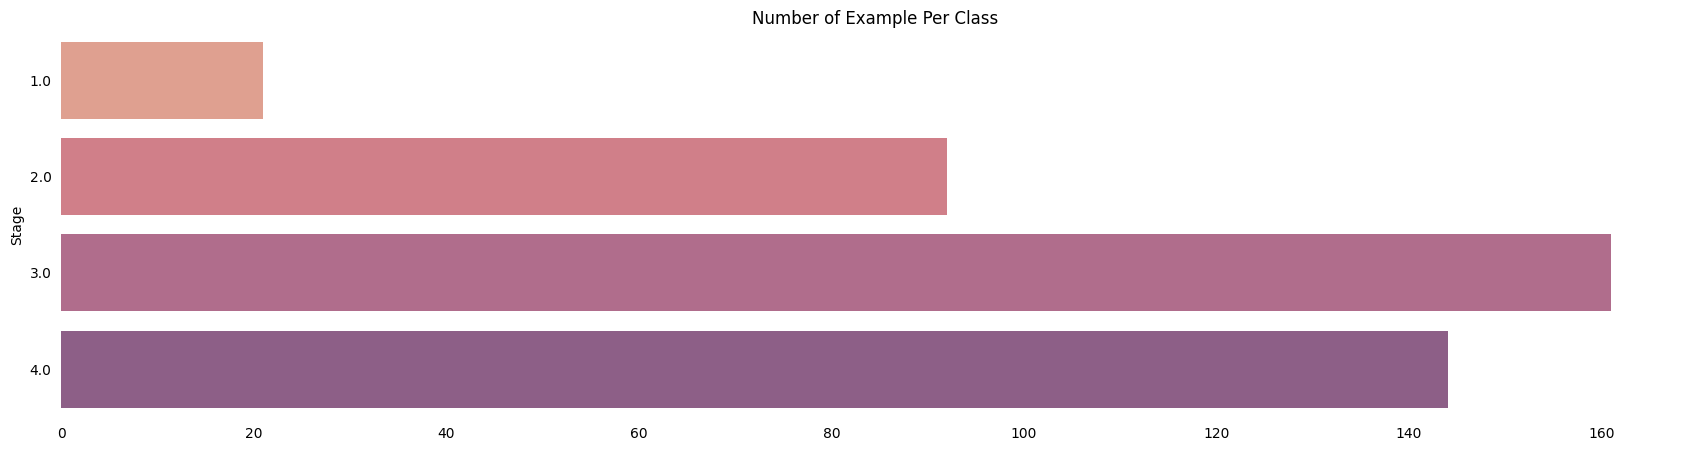

In [11]:
plt.figure(figsize=(21,5))
sns.countplot(y=df['Stage'], palette="flare", alpha=0.8, )
sns.despine(top=True, right=True, bottom=True, left=True)
plt.tick_params(axis='both', which='both', bottom=False, top=False, left=False)
plt.xlabel('')
plt.title('Number of Example Per Class')

As we can observe we have class imbalances in our dataset i.e some classes have more examples than other. This could make it difficult for our model to train and achieve desired score. No worries, we can fix that later.

# Setting up Target and Features

### For this demonstration we will keep things simple by predicting one of the two classes  i.e (Cirrhosis and No Cirrhois). 

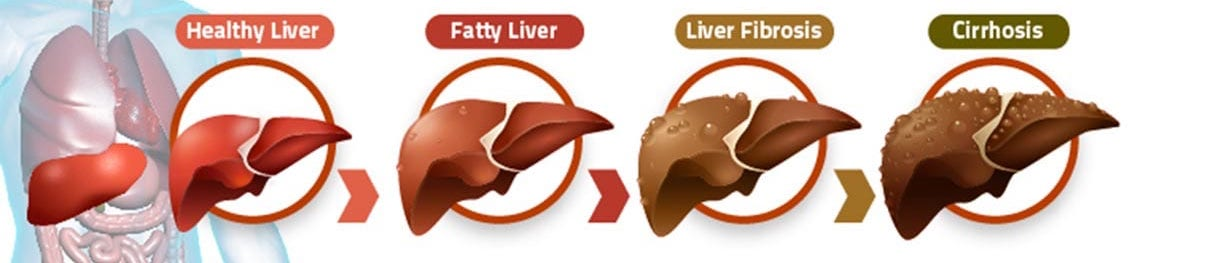

In [12]:
# Converting Target categories into intigers 1 for Cirrhosis, 0 otherwise
df['Stage'] = np.where(df['Stage'] == 4,1,0)

## Lets observe some Features with their relation with the disease

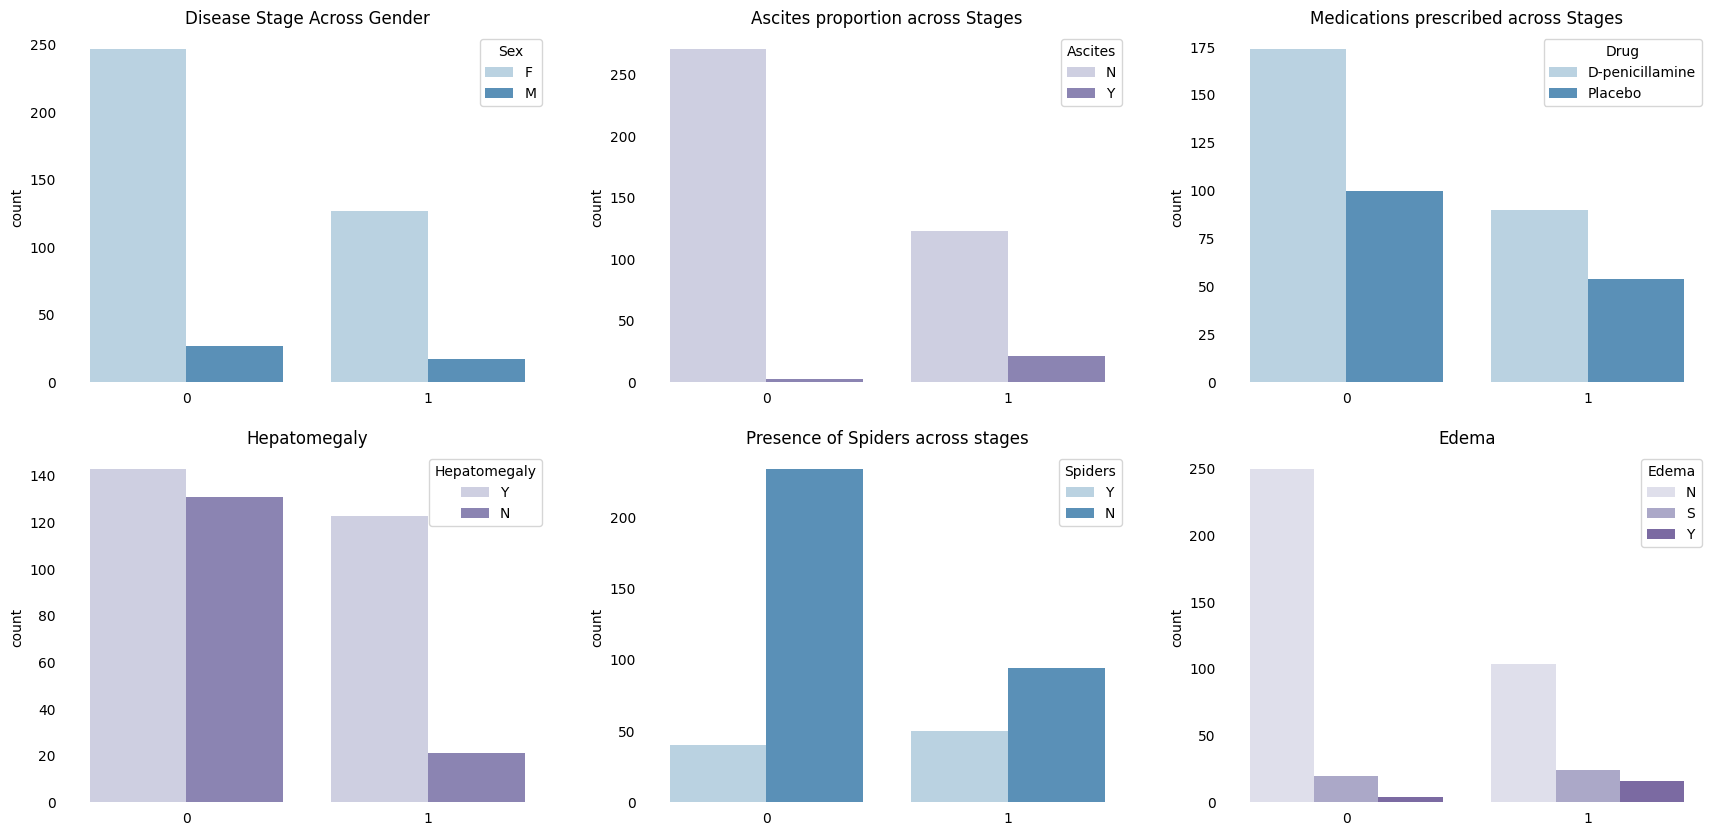

In [13]:
plt.figure(figsize=(21.2,10))

plt.subplot(2,3,1)
sns.countplot(x=df['Stage'], hue=df['Sex'], palette='Blues', alpha=0.9)
sns.despine(top=True, right=True, bottom=True, left=True)
plt.tick_params(axis='both', which='both', bottom=False, top=False, left=False)
plt.xlabel('')
plt.title('Disease Stage Across Gender')

plt.subplot(2,3,2)
sns.countplot(x=df['Stage'], hue=df['Ascites'], palette='Purples', alpha=0.9)
sns.despine(top=True, right=True, bottom=True, left=True)
plt.tick_params(axis='both', which='both', bottom=False, top=False, left=False)
plt.xlabel('')
plt.title('Ascites proportion across Stages')

plt.subplot(2,3,3)
sns.countplot(x=df['Stage'], hue=df['Drug'], palette='Blues', alpha=0.9)
sns.despine(top=True, right=True, bottom=True, left=True)
plt.tick_params(axis='both', which='both', bottom=False, top=False, left=False)
plt.xlabel('')
plt.title('Medications prescribed across Stages');

plt.subplot(2,3,4)
sns.countplot(x=df['Stage'], hue=df['Hepatomegaly'], palette='Purples', alpha=0.9)
sns.despine(top=True, right=True, bottom=True, left=True)
plt.tick_params(axis='both', which='both', bottom=False, top=False, left=False)
plt.xlabel('')
plt.title('Hepatomegaly');

plt.subplot(2,3,5)
sns.countplot(x=df['Stage'], hue=df['Spiders'], palette='Blues', alpha=0.9)
sns.despine(top=True, right=True, bottom=True, left=True)
plt.tick_params(axis='both', which='both', bottom=False, top=False, left=False)
plt.xlabel('')
plt.title('Presence of Spiders across stages');

plt.subplot(2,3,6)
sns.countplot(x=df['Stage'], hue=df['Edema'], palette='Purples', alpha=0.9)
sns.despine(top=True, right=True, bottom=True, left=True)
plt.tick_params(axis='both', which='both', bottom=False, top=False, left=False)
plt.xlabel('')
plt.title('Edema');

There are some interesting insights if we observe closely. Take the case at Ascites, we observe that the rist of disease is higher with increase in Ascites. also presence of spiders has a positive relation with disease risk.

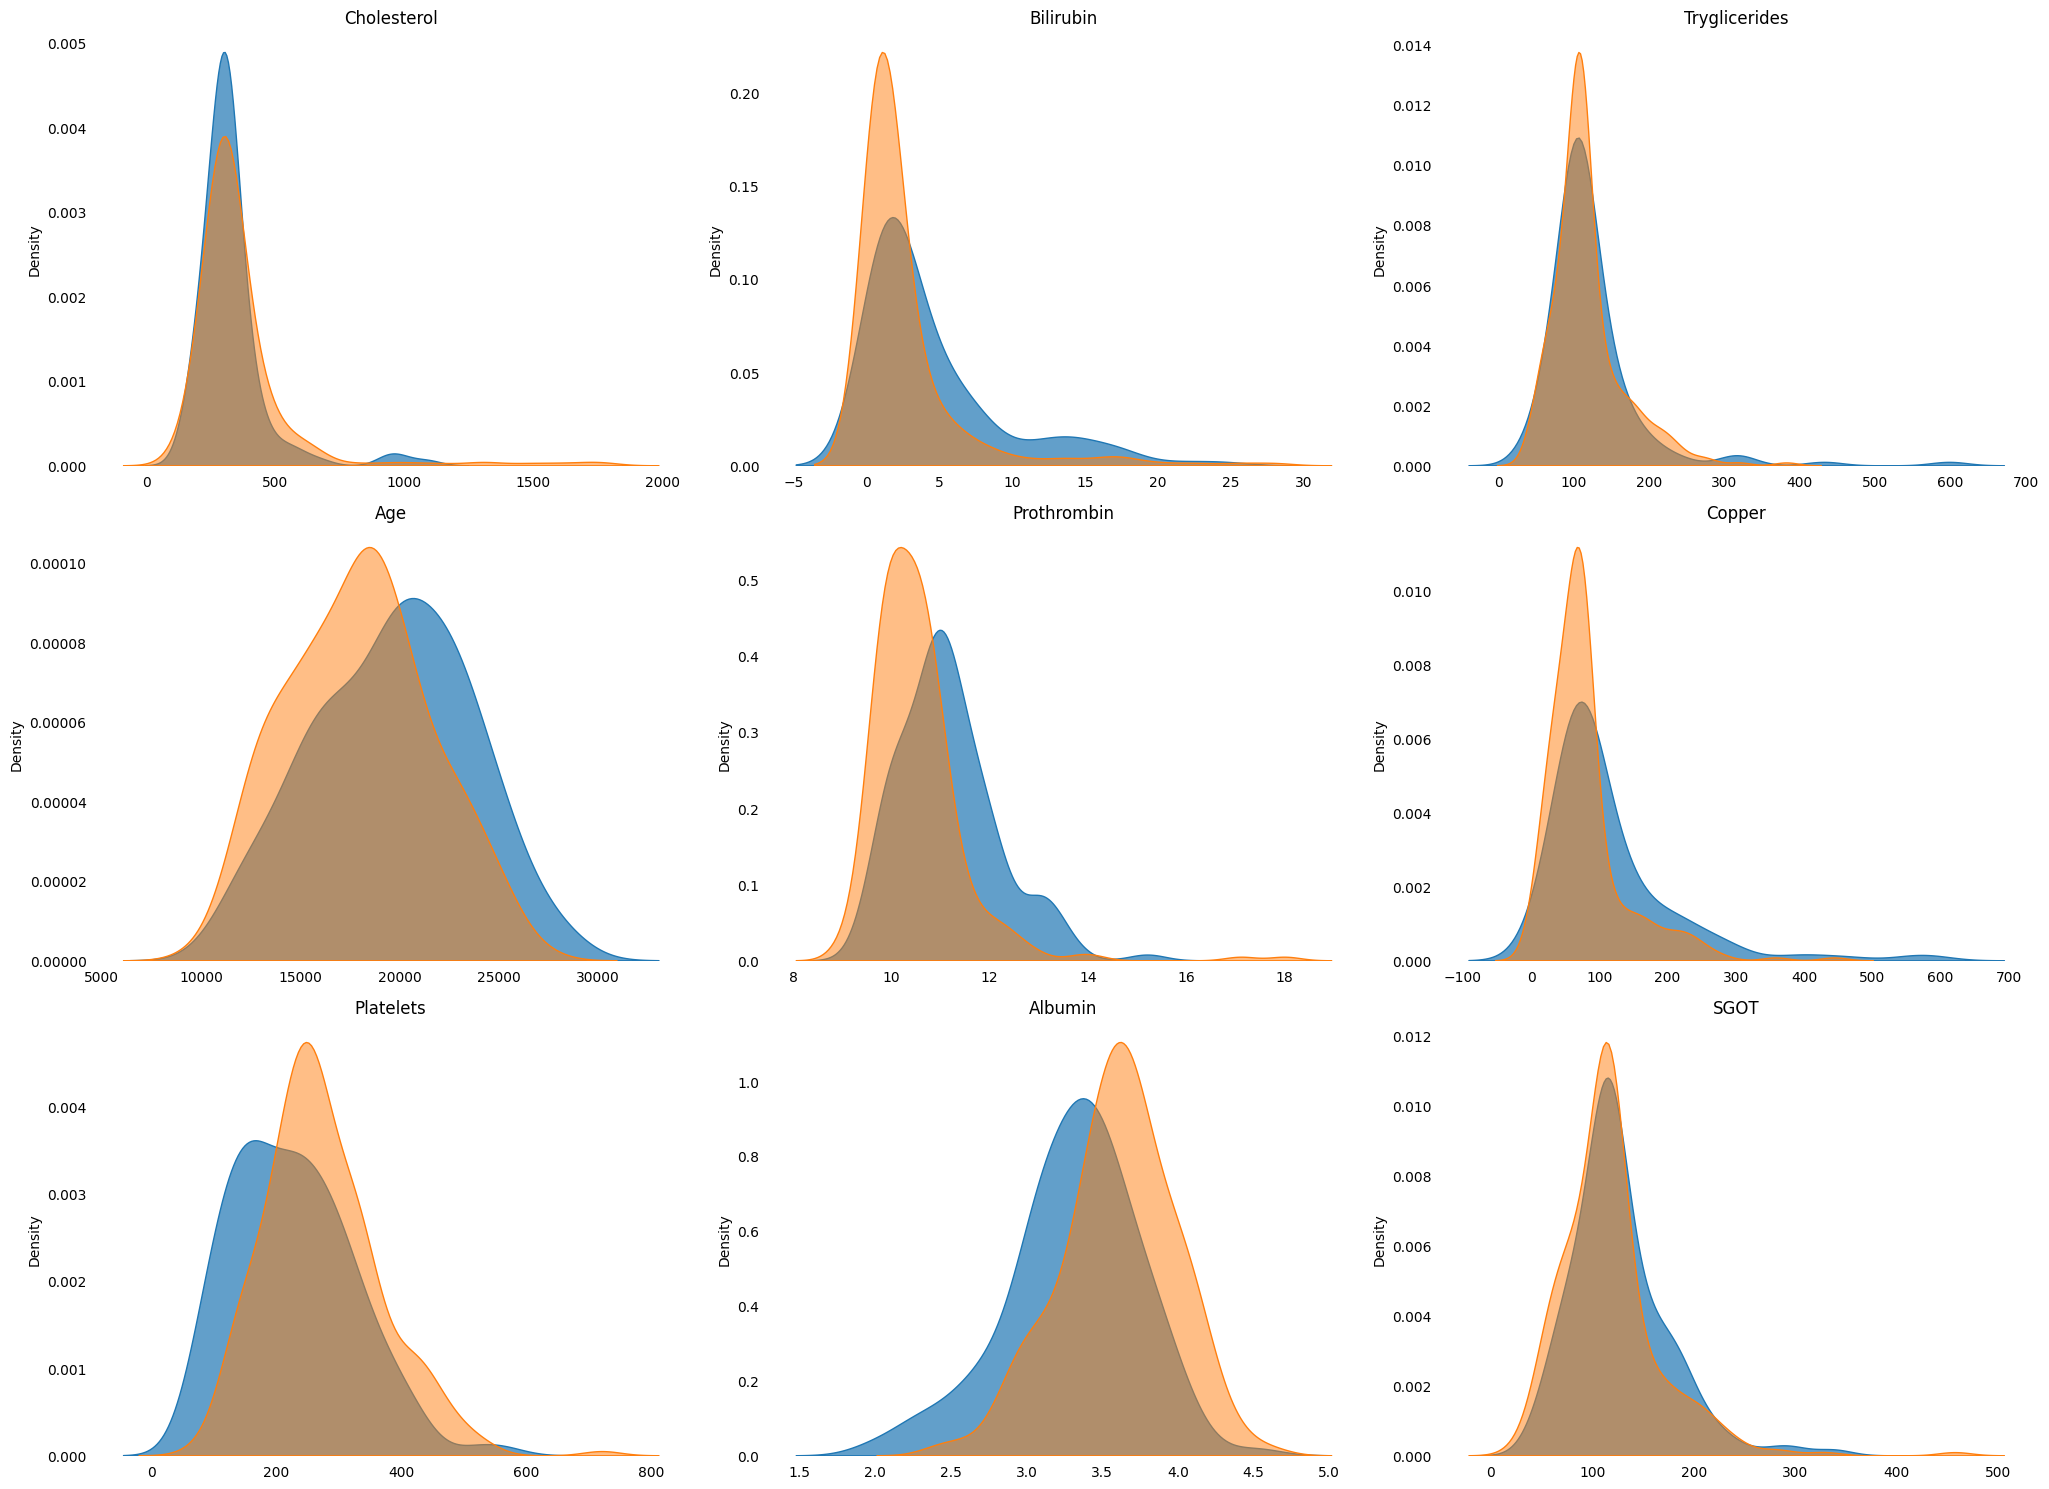

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming df has columns with names mentioned in the code

plt.figure(figsize=(20.6, 15))  # Adjust figsize as needed

# Define transparency levels (adjust alpha values as needed)
alphas = [0.7, 0.5, 0.3]  # Adjust the number of alphas based on unique stages

# Loop through features (assuming they are columns in df)
features = ['Cholesterol', 'Bilirubin', 'Tryglicerides', 'Age', 'Prothrombin', 'Copper', 'Platelets', 'Albumin', 'SGOT']
row_counter = 1

for feature in features:
    plt.subplot(3, 3, row_counter)
    for stage, alpha in zip(df['Stage'].unique(), alphas):
        data_subset = df[df['Stage'] == stage]
        sns.kdeplot(data=data_subset, x=feature, fill=True, alpha=alpha)
    sns.despine(top=True, right=True, bottom=True, left=True)
    plt.tick_params(axis='both', which='both', bottom=False, top=False, left=False)
    plt.xlabel('')
    plt.title(feature)
    row_counter += 1

plt.tight_layout()  # Adjust spacing between subplots
plt.show()


### Looking at the feature distribution we can observe that in features such as Age, Prothrombin, Copper the risk of the disease increase with increase in feature value, thus having a positive co-relation on with the disease probability. Lets fit a regression line to check.

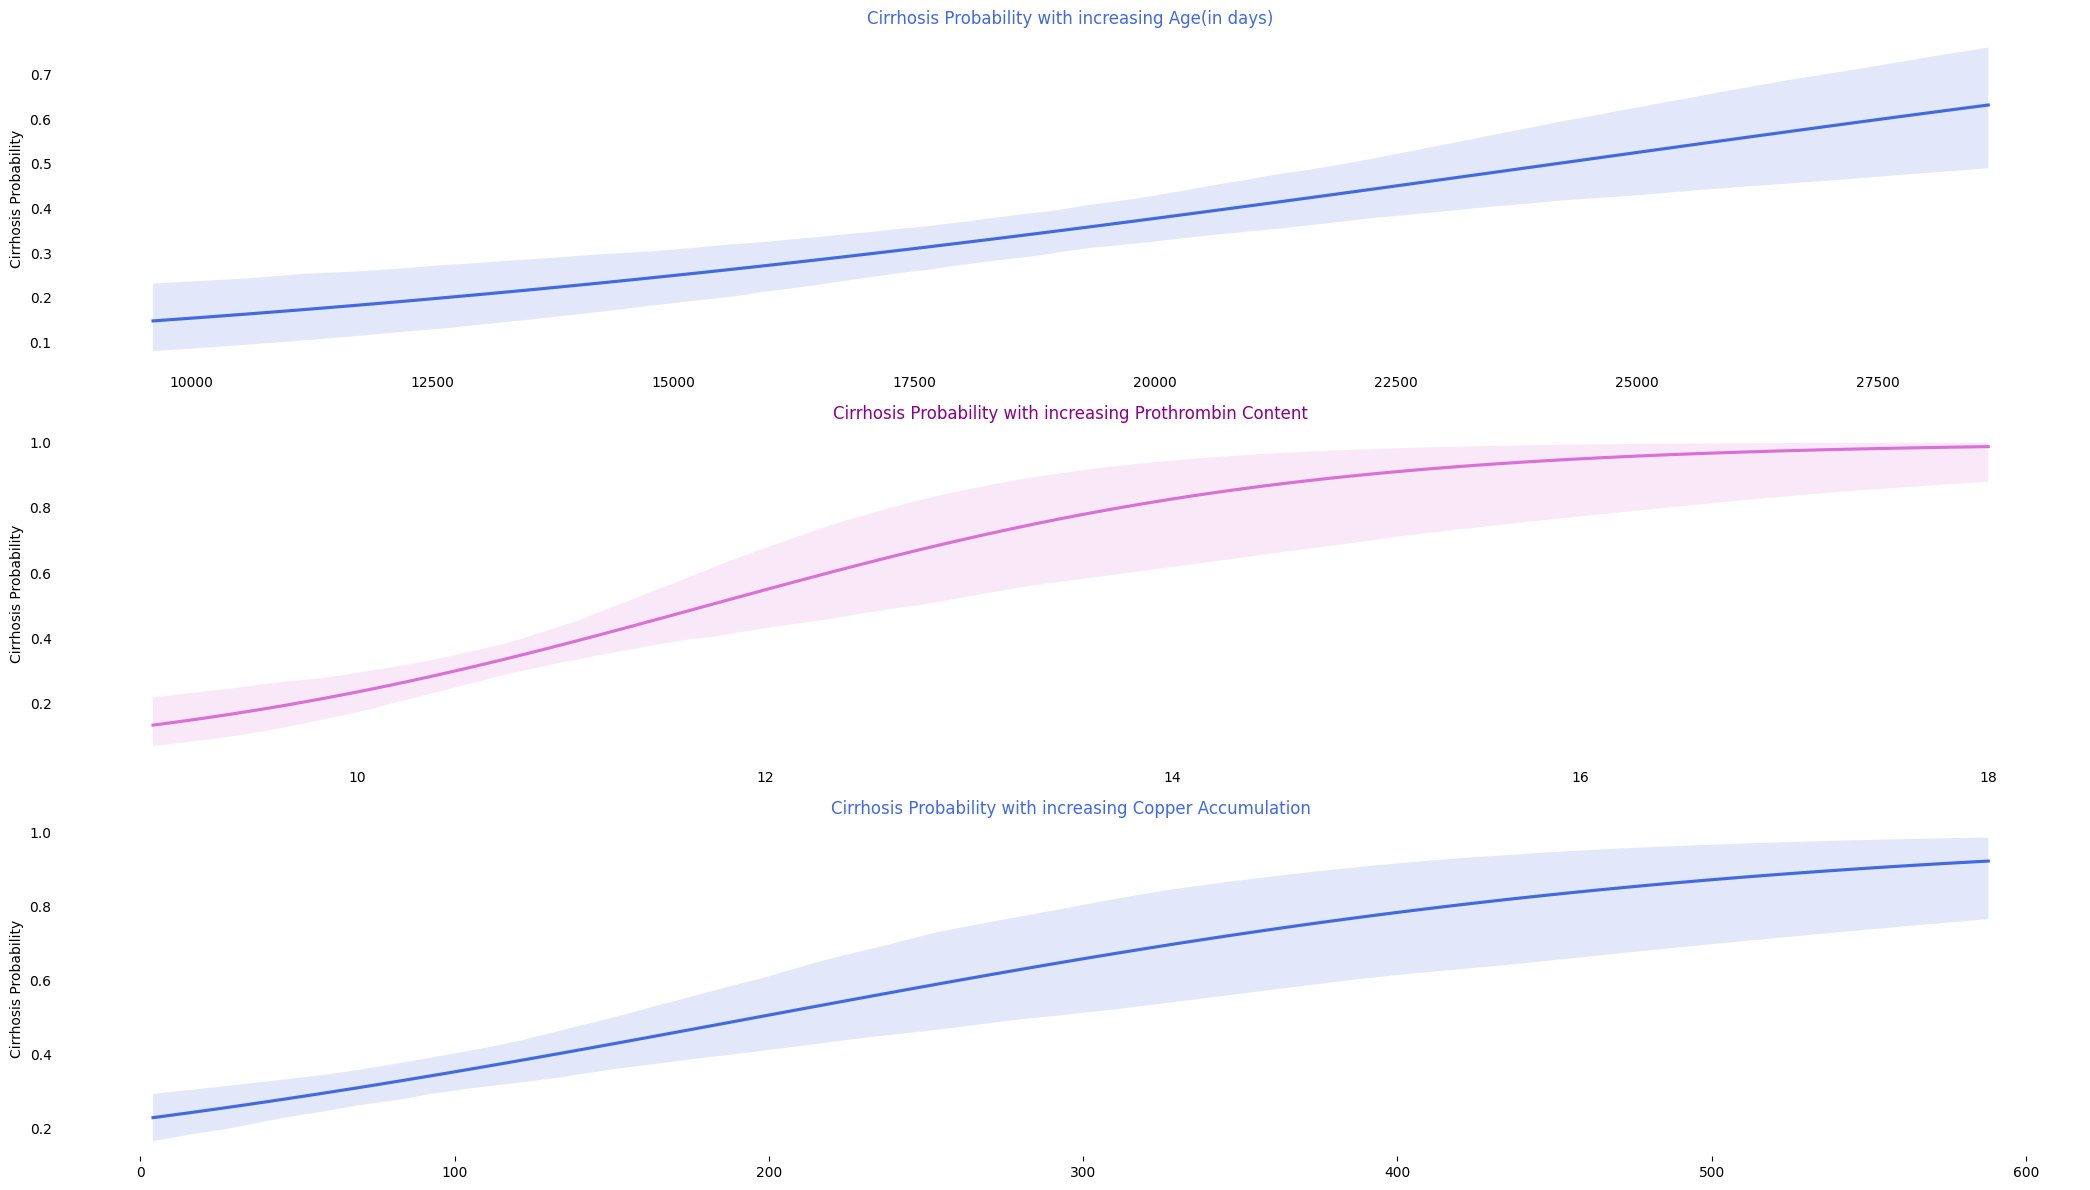

In [15]:


import seaborn as sns
import matplotlib.pyplot as plt

# Assuming df has columns with names mentioned in the code

plt.figure(figsize=(21, 12))

plt.subplot(3, 1, 1)
sns.regplot(x=df['Age'], y=df['Stage'], scatter=False, logistic=True, color='royalblue')
sns.despine(top=True, right=True, bottom=True, left=True)
plt.tick_params(axis='both', which='both', bottom=False, top=False, left=False)
plt.xlabel('')
plt.ylabel('Cirrhosis Probability')
plt.setp(plt.title('Cirrhosis Probability with increasing Age(in days)'), color='royalblue')

plt.subplot(3, 1, 2)
sns.regplot(x=df['Prothrombin'], y=df['Stage'], scatter=False, logistic=True, color='orchid')
sns.despine(top=True, right=True, bottom=True, left=True)
plt.tick_params(axis='both', which='both', bottom=False, top=False, left=False)
plt.xlabel('')
plt.ylabel('Cirrhosis Probability')
plt.setp(plt.title('Cirrhosis Probability with increasing Prothrombin Content'), color='darkmagenta')

plt.subplot(3, 1, 3)
sns.regplot(x=df['Copper'], y=df['Stage'], scatter=False, logistic=True, color='royalblue')
sns.despine(top=True, right=True, bottom=True, left=True)
plt.tick_params(axis='both', which='both', top=False, left=False)  # Adjusted bottom tick removal
plt.xlabel('')
plt.ylabel('Cirrhosis Probability')
plt.setp(plt.title('Cirrhosis Probability with increasing Copper Accumulation'), color='royalblue')

plt.tight_layout()
plt.show()


Looks like the data checks with our intuition. These parameters indeed increase the risk of the disease.

### We can also observe some features such as Platelets, Albumin, Cholesterol where the probability of disease decrease with increase in feature value. Lets tally that with some more regression plots.

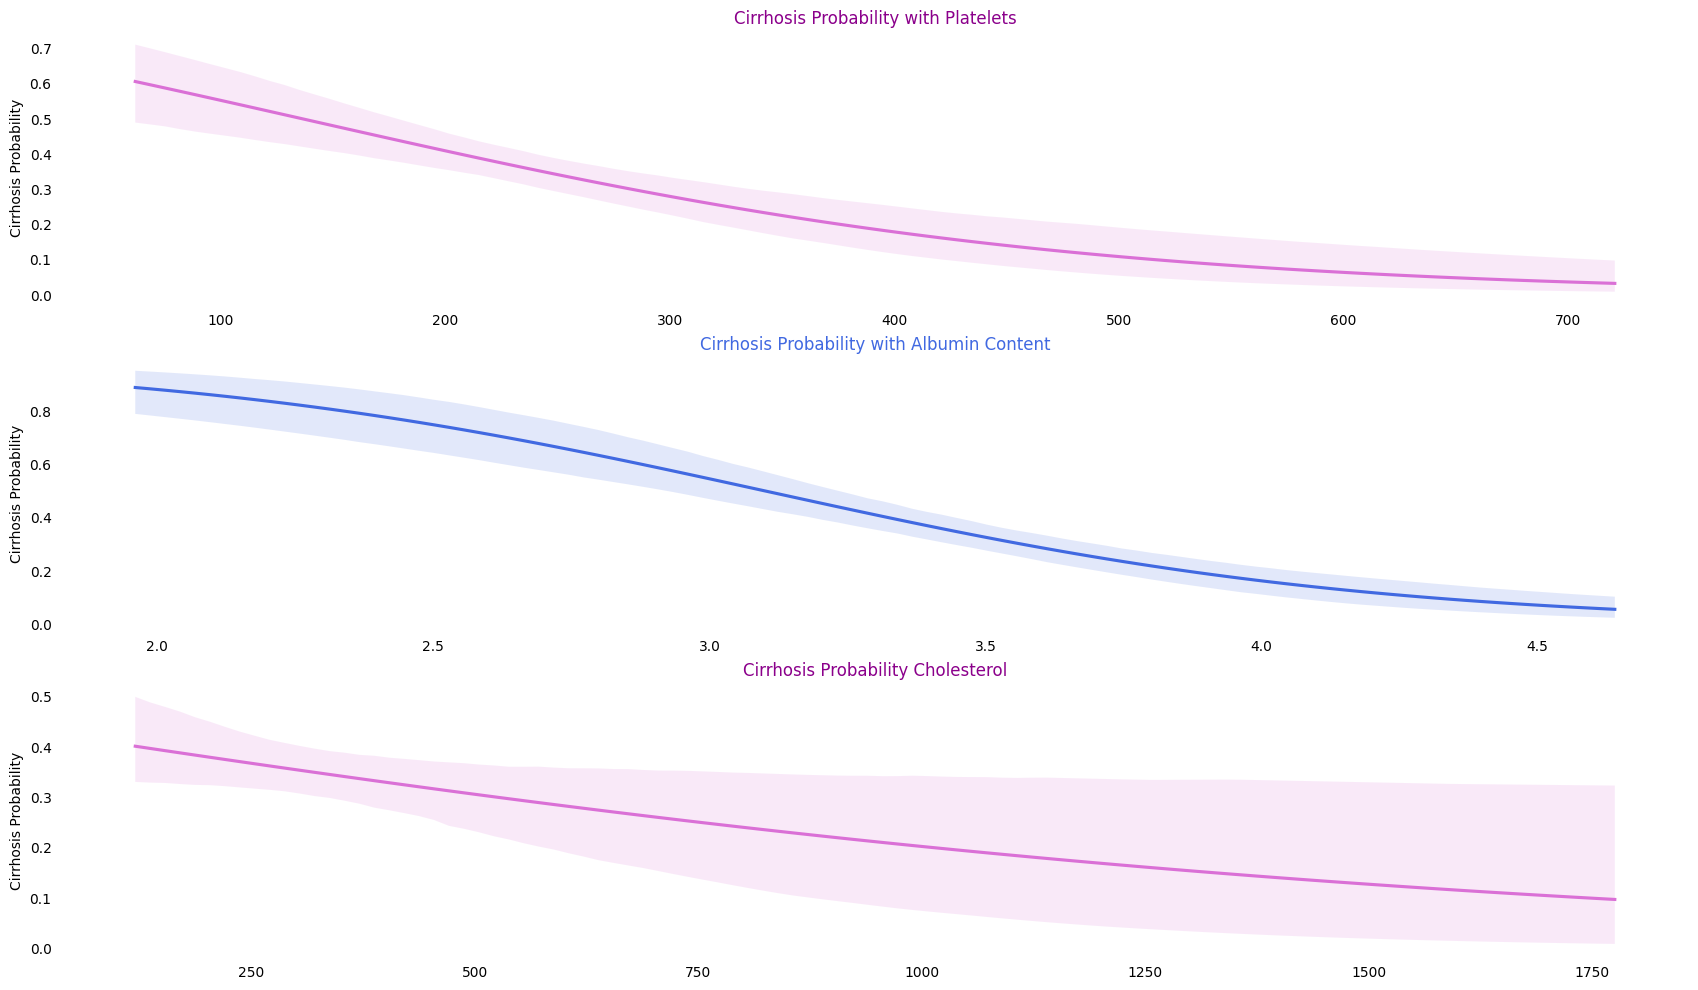

In [16]:
#@title Regression Plots of negatively correlated Features.
plt.figure(figsize=(21,12))

plt.subplot(3,1,1)
sns.regplot(x=df['Platelets'], y=df['Stage'], scatter=False, logistic=True, color='orchid')
sns.despine(fig=None, ax=None, top=True, right=True, left=True, bottom=True, offset=None, trim=False);
plt.tick_params(axis='both', which='both', bottom=False, top=False, left=False)
plt.xlabel('');
plt.ylabel('Cirrhosis Probability');
plt.setp(plt.title('Cirrhosis Probability with Platelets'), color='darkmagenta');

plt.subplot(3,1,2)
sns.regplot(x=df['Albumin'], y=df['Stage'], scatter=False, logistic=True, color='royalblue');
sns.despine(fig=None, ax=None, top=True, right=True, left=True, bottom=True, offset=None, trim=False);
plt.tick_params(axis='both', which='both', bottom=False, top=False, left=False)
plt.xlabel('');
plt.ylabel('Cirrhosis Probability');
plt.setp(plt.title('Cirrhosis Probability with Albumin Content'), color='royalblue');

plt.subplot(3,1,3)
sns.regplot(x=df['Cholesterol'], y=df['Stage'], scatter=False, logistic=True, color='orchid')
sns.despine(fig=None, ax=None, top=True, right=True, left=True, bottom=True, offset=None, trim=False);
plt.tick_params(axis='both', which='both', bottom=False, top=False, left=False)
plt.xlabel('');
plt.ylabel('Cirrhosis Probability');
plt.setp(plt.title('Cirrhosis Probability Cholesterol'), color='darkmagenta') ;

Platelets, Albumin checks with our logic the findings about Cholesterol seems interesting! Looks like people with high Cholesterol have lower risk of Cirrhosis, this might not sound correct but our data certainly shows so. 

This should help our model predict the target. We will be looking at what features contribute the most in later part of the project.

# Preprocessing data

In [17]:
# replacing catagorical data with intigers.
df['Sex'] = df['Sex'].replace({'M':0, 'F':1})                                # Male : 0 , Female :1
df['Ascites'] = df['Ascites'].replace({'N':0, 'Y':1})                        # N : 0, Y : 1   
df['Drug'] = df['Drug'].replace({'D-penicillamine':0, 'Placebo':1})          # D-penicillamine : 0, Placebo : 1   
df['Hepatomegaly'] = df['Hepatomegaly'].replace({'N':0, 'Y':1})              # N : 0, Y : 1
df['Spiders'] = df['Spiders'].replace({'N':0, 'Y':1})                        # N : 0, Y : 1
df['Edema'] = df['Edema'].replace({'N':0, 'Y':1, 'S':-1})                    # N : 0, Y : 1, S : -1
df['Status'] = df['Status'].replace({'C':0, 'CL':1, 'D':-1})                 # 'C':0, 'CL':1, 'D':-1

## We will not be using 'Status' and 'N_days' as our features since this will cause data Leakage.

In [18]:
# Setting up Features and Target
X = df.drop(['Status', 'N_Days', 'Stage'], axis=1)
y = df.pop('Stage')

### Earlier while examining the distribution of target in the data, we found that the data is unevenly distributed, that is there are more examples of a certain class than other. 

###To tackel this imbalance we will use **Stratified k-Fold** Cross Validation.

# Model

## Gradient Boosted Classifier from **XGboost**.

In [23]:
from sklearn.model_selection import StratifiedKFold
from xgboost import XGBClassifier
skf = StratifiedKFold(n_splits=10, random_state=1, shuffle=True)
model = XGBClassifier(learning_rate=0.75, max_depth=3, random_state=1, gamma=0, eval_metric='error') # tried learning rate values between range [0.01 - 10] & depth [2-8]

acc=[]
def training(train, test, fold_no):
  X_train = train
  y_train = y.iloc[train_index]
  X_test = test
  y_test = y.iloc[test_index]
  model.fit(X_train, y_train)
  score = model.score(X_test,y_test)
  acc.append(score)
  print('For Fold {} the accuracy is {}'.format(str(fold_no),score))

fold_no = 1
for train_index,test_index in skf.split(X, y):
  train = X.iloc[train_index,:]
  test = X.iloc[test_index,:]
  training(train, test, fold_no)
  fold_no += 1
print()
print('XGboost model Mean Accuracy = ', np.mean(acc))

For Fold 1 the accuracy is 0.7619047619047619
For Fold 2 the accuracy is 0.7857142857142857
For Fold 3 the accuracy is 0.7380952380952381
For Fold 4 the accuracy is 0.7619047619047619
For Fold 5 the accuracy is 0.8095238095238095
For Fold 6 the accuracy is 0.7380952380952381
For Fold 7 the accuracy is 0.7619047619047619
For Fold 8 the accuracy is 0.7857142857142857
For Fold 9 the accuracy is 0.7073170731707317
For Fold 10 the accuracy is 0.7560975609756098

XGboost model Mean Accuracy =  0.7606271777003484


In [24]:
from sklearn.metrics import classification_report
XGB_model_predict = model.predict(test)
XGB_model_predict_proba = model.predict_proba(test)

print(classification_report(y.iloc[test_index], XGB_model_predict))

              precision    recall  f1-score   support

           0       0.77      0.89      0.83        27
           1       0.70      0.50      0.58        14

    accuracy                           0.76        41
   macro avg       0.74      0.69      0.71        41
weighted avg       0.75      0.76      0.74        41



## Thats a significant improvement over the logestic regression. We now have about **with about 76% accuracy**. This is pretty remarkable considering we only have about **400 training examples!**